In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import datetime as dt


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

from tensorflow import keras

SEED=3021995

In [2]:
path = '/datasets/final_steel/'

data_arc = pd.read_csv(path +'data_arc.csv')
data_bulk = pd.read_csv(path + 'data_bulk.csv')
data_bulk_time = pd.read_csv(path + 'data_bulk_time.csv')
data_gas = pd.read_csv(path + 'data_gas.csv')
data_temp =pd.read_csv(path + 'data_temp.csv')
data_wire = pd.read_csv(path + 'data_wire.csv')
data_wire_time = pd.read_csv(path + 'data_wire_time.csv')

In [3]:
#функция выбросы
def count_fliers(data, column):
    boxplot = plt.boxplot(data[column].values)
    plt.boxplot(data[column], autorange=True)
    plt.title(column)
    plt.show()
    outliers = list(boxplot["fliers"][0].get_data()[1])
    print("Выбросов в {}: ".format(column), len(outliers)) 
    print('Доля выбросов в {}: {:.2%}'.format(column, len(outliers)/len(data[column])))

# 1. Исследовательский анализ данных
### Data Arc 
Данные об электродах.

In [4]:

data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [5]:

data_arc.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

In [6]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [7]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [8]:
# значения key-итераций
print(data_arc['key'].value_counts())
print()
print('Уникальных значений key в data_ark',len(data_arc['key'].unique()))

2108    16
1689    15
1513    15
2567    14
322     13
        ..
614      1
1914     1
2025     1
2795     1
1568     1
Name: key, Length: 3214, dtype: int64

Уникальных значений key в data_ark 3214


In [9]:
## даты
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y.%m.%dT%H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y.%m.%dT%H:%M:%S')
data_arc['Длительность нагрева дугой'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
#print(data_arc.info()) #норм

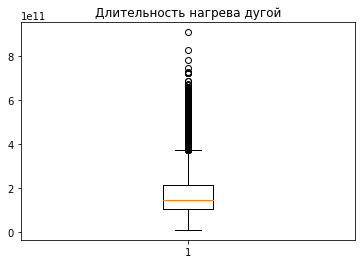

Минимальная длительность 0 days 00:00:11
Медианная длительность 0 days 00:02:27
Максимальная длительность 0 days 00:15:07


In [10]:
plt.boxplot(data_arc['Длительность нагрева дугой'])
plt.title('Длительность нагрева дугой')
plt.show()
print('Минимальная длительность',data_arc['Длительность нагрева дугой'].min())
print('Медианная длительность', data_arc['Длительность нагрева дугой'].median())
print('Максимальная длительность', data_arc['Длительность нагрева дугой'].max())

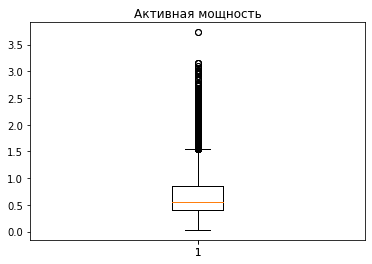

Выбросов в Активная мощность:  569
Доля выбросов в Активная мощность: 3.82%


In [12]:
# Активная мощность
count_fliers(data_arc, 'Активная мощность')

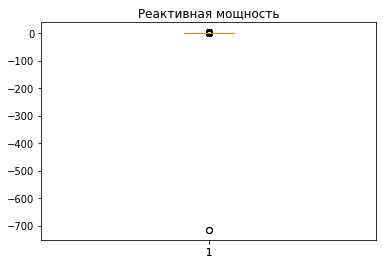

Выбросов в Реактивная мощность:  601
Доля выбросов в Реактивная мощность: 4.04%


In [13]:
#Реактивная мощность
count_fliers(data_arc, 'Реактивная мощность')

#### Выводы по таблице data_arc
- Таблица состоит из 5 столбцов, из них 
   - key - номер партии, категориальный, уникальных значений - 3214
   - Начало нагрева дугой и конец нагрева дугой - временные отметки событий
   - Активная мощность, реактивная мощность - количественные
- Пропусков нет
- всего 14876 объектов
- минимальная длительность нагрева - 11 секунд, максимальная - 15 минут 7 секунд
- Доля выбросов в столбце начало нагрева дугой - 3.82%
- Доля выбросов в столбце конец нагрева дугой - 4.04%

###  Data bulk
Данные о подаче сыпучих материалов

In [14]:
display(data_bulk.head())
display(data_bulk.tail())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


In [15]:
print(data_bulk.isna().sum())

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


In [16]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [17]:
print('Уникальных значений key в data_ark: ',len(data_arc['key'].unique()))
print('Кол-во уникльных значений key в data_bulk: ', len(data_bulk['key'].unique()))

Уникальных значений key в data_ark:  3214
Кол-во уникльных значений key в data_bulk:  3129


In [18]:
print(data_bulk.columns[1:20])

Index(['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7',
       'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13',
       'Bulk 14', 'Bulk 15'],
      dtype='object')


#### Выводы по таблице data_bulk
- В таблице содержатся массы примесей по каждому номеру партии
- Кол-во уникальных номеров партий незначительно отличаются от кол-ва уникальных номеров партий в data_ark. Возможно, есть строки без примесей.

### data_bulk_time

In [20]:
display(data_bulk_time.head())
display(data_bulk_time.tail())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 04:05:34,2019-09-01 04:05:34


In [21]:
print('Кол-во объектов в data bulk: ', len(data_bulk))

Кол-во объектов в data bulk:  3129


In [22]:
bulk_nas = pd.DataFrame(data_bulk.isna().sum(), columns=['NA_num'])
bulk_nas['NA_percent'] = (bulk_nas['NA_num']/len(data_bulk)*100).round(2)
print(bulk_nas.sort_values(by='NA_percent'))

         NA_num  NA_percent
key           0        0.00
Bulk 14     323       10.32
Bulk 12     679       21.70
Bulk 15     881       28.16
Bulk 3     1831       58.52
Bulk 4     2115       67.59
Bulk 6     2553       81.59
Bulk 1     2877       91.95
Bulk 11    2952       94.34
Bulk 10    2953       94.38
Bulk 5     3052       97.54
Bulk 7     3104       99.20
Bulk 2     3107       99.30
Bulk 9     3110       99.39
Bulk 13    3111       99.42
Bulk 8     3128       99.97


In [23]:

print(data_bulk_time.isna().sum())

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


In [24]:
print('Уникальных значений key в data_ark: ',len(data_arc['key'].unique()))
print('Кол-во уникльных значений key в data_bulk: ', len(data_bulk['key'].unique()))
print('Кол-во уникльных значений key в data_bulk_time: ', len(data_bulk_time['key'].unique()))

Уникальных значений key в data_ark:  3214
Кол-во уникльных значений key в data_bulk:  3129
Кол-во уникльных значений key в data_bulk_time:  3129


#### Выводы по таблице data_bulk_time
- Пропуски совпадают с таблицей data_bulk
- Кол-во уникальных значений key совпадает с data_bulk
- По некоторым примесям имеется очень мало данных, от 1 объекта(при том, что всего их 3129)

### data_gas

In [25]:
print(data_gas)

       key      Газ 1
0        1  29.749986
1        2  12.555561
2        3  28.554793
3        4  18.841219
4        5   5.413692
...    ...        ...
3234  3237   5.543905
3235  3238   6.745669
3236  3239  16.023518
3237  3240  11.863103
3238  3241  12.680959

[3239 rows x 2 columns]


In [26]:
print(data_gas.isna().sum())

key      0
Газ 1    0
dtype: int64


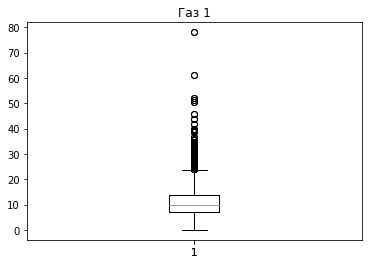

Выбросов в Газ 1:  126
Доля выбросов в Газ 1: 3.89%


In [27]:
count_fliers(data_gas, 'Газ 1')

In [28]:
print('Уникальных значений key в data_ark: ',len(data_arc['key'].unique()))
print('Кол-во уникльных значений key в data_bulk: ', len(data_bulk['key'].unique()))
print('Кол-во уникльных значений key в data_bulk_time: ', len(data_bulk_time['key'].unique()))
print('Кол-во уникльных значений key в data_gas: ', len(data_gas['key'].unique()))

Уникальных значений key в data_ark:  3214
Кол-во уникльных значений key в data_bulk:  3129
Кол-во уникльных значений key в data_bulk_time:  3129
Кол-во уникльных значений key в data_gas:  3239


#### Выводы по data_gas
- Всего два столбца, номер партии и содержания газа
- Пропусков нет
- Доля выбросов 3.89% 
- Кол-во уникалных значений key не совпадает с другими таблицами - их 3239

### data_temp
результаты измерения температуры

In [29]:
display(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [30]:
display(data_temp.isna().sum())
print()
print('Доля пропусков в столбце Температура: {:.2%}'.format(data_temp['Температура'].isna().sum()/len(data_temp)))

key                0
Время замера       0
Температура     2901
dtype: int64


Доля пропусков в столбце Температура: 18.24%


In [31]:
print(data_temp['Температура'].describe())

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64


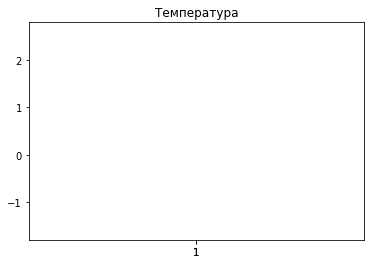

Выбросов в Температура:  0
Доля выбросов в Температура: 0.00%


In [32]:
count_fliers(data_temp, 'Температура')  ### не работает(


#### Выводы по таблице data_temp

- В таблице 15907 объектов
- Три столбца, key, время замера, температура при замере
- в столбце температуры 18.24% пропусков

## data_wire

In [33]:
display(data_wire.head())
display(data_wire.tail())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
print(data_wire.shape)

(3081, 10)


In [35]:
#print(data_wire.info()) ## тут все ок
print(data_wire.isna().sum())

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


In [36]:
wire_nas = pd.DataFrame(data_wire.isna().sum(), columns=['NA_num'])
wire_nas['NA_percent'] = (wire_nas['NA_num']/len(data_wire)*100).round(2)

In [37]:
print(wire_nas)

        NA_num  NA_percent
key          0        0.00
Wire 1      26        0.84
Wire 2    2002       64.98
Wire 3    3018       97.96
Wire 4    3067       99.55
Wire 5    3080       99.97
Wire 6    3008       97.63
Wire 7    3070       99.64
Wire 8    3062       99.38
Wire 9    3052       99.06


In [38]:
display(data_wire_time.head())
display(data_wire_time.tail())


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-01 04:16:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
wire_time_nas = pd.DataFrame(data_wire_time.isna().sum(), columns=['NA_num'])
wire_time_nas['NA_percent'] = (wire_time_nas['NA_num']/len(data_wire_time)*100).round(2)

In [40]:
print(wire_time_nas)

        NA_num  NA_percent
key          0        0.00
Wire 1      26        0.84
Wire 2    2002       64.98
Wire 3    3018       97.96
Wire 4    3067       99.55
Wire 5    3080       99.97
Wire 6    3008       97.63
Wire 7    3070       99.64
Wire 8    3062       99.38
Wire 9    3052       99.06


### Выводы по data_wire
- В большей части столбцов очень мало данных, менее 95%
- Можно заполнить нулями, скорее всего это нулевые содержания.
- пропуски совпадают с пропусками в таблице с временными метками

# Общие выводы
- В таблице data_wire информативными являются только столбцы Wire1 и Wire2. Но скорее всего пропуски - это нулевое содержание проволочных материалов,  а не пропуски.


# Уточняющие вопросы
- Целевой признак содержится в таблице data_bulk?
- Почему не отобразился boxplot таблицы data_temp столбец Темература
- Как создавать один объект, объединяя все эти таблицы? Возможно, стоит сделать pivot по key? Но тогда брать средний показатель, или максимальный? или время замеров на абсолютно всех датчиках одно и то же и по сути побъеты объединяются построчно?

# План работы
1. Предобработка. Заполнить нулями где можно. 
2. Отбор данных, соединение в общую таблицу. Необходимо определить, какие данные будут использоваться для обучения. Я думаю, стоит отталкиваться от наличия соответсвующего целевого признака.
3. Шкалирование(?). Возможно, стоит подготовить количественные признаки к регрессии.
4. Выбор модели. Через кроссвалидацию. Я буду выбирать между линейной регрессией, catboost, своей моделью с 2 полносвязными скрытыми слоями.
5. Предсказание, измерение качества предсказания. На этом этапе, возможно, прийдется вернуться обратно.
6. Интерпретация результатов.

# 2. Предобработка
- Предобработка. Заполнить нулями где можно.
- Отбор данных, соединение в общую таблицу. Необходимо определить, какие данные будут использоваться для обучения. Я думаю, стоит отталкиваться от наличия соответсвующего целевого признака.

###### памятка
- data_arc 
- data_bulk
- data_bulk_time 
- data_gas
- data_temp
- data_wire
- data_wire_time

### 2.1 Выбросы

In [41]:
def del_extreme_fliers(df, col, upper_threshold, lower_threshold):
    clear_df = df.loc[df[col] < upper_threshold, df.columns]
    clear_df = clear_df.loc[df[col] > lower_threshold, df.columns]
    print('Кол-во объектов после удаления выбросов:', clear_df.shape[0])
    return clear_df



def show_extreme_fliers(df, col, if_del=False):
    data = df[col]
    q75 = np.percentile(data, 75)
    q25 = np.percentile(data, 25)
    irq = q75 - q25
    upper_threshold_flier = q75 + (3*irq)
    lower_threshold_flier = q25 - (3*irq)
    print('Верхняя граница экстремальных выбросов:', upper_threshold_flier)
    print('Нижняя граница экстремальных выбросов:', lower_threshold_flier)
    
    if if_del == True:
        print()
        print('Кол-во объектов до удаления выбросов:', df.shape[0])
        print('Кол-во удаленных объектов-верхних выбросов:', len(df.loc[df[col] >= upper_threshold_flier])) 
        print('Кол-во удаленных нижних выбросов:', len(df.loc[df[col] <= lower_threshold_flier]))
        clear_df = del_extreme_fliers(df, col, upper_threshold_flier, lower_threshold_flier)
        #print('Кол-во объектов после удаления выбросов:', df.shape[0])
        return clear_df
        
        
def control_fliers(df):
    print('Объектов после удаления и записи', df.shape[0])

In [42]:
data_arc = show_extreme_fliers(data_arc, 'Активная мощность', if_del=True)
#print(data_arc)
#control_fliers(data_arc)

Верхняя граница экстремальных выбросов: 2.2422433057499993
Нижняя граница экстремальных выбросов: -0.9899122950499996

Кол-во объектов до удаления выбросов: 14876
Кол-во удаленных объектов-верхних выбросов: 94
Кол-во удаленных нижних выбросов: 0
Кол-во объектов после удаления выбросов: 14782


In [43]:
data_arc = show_extreme_fliers(data_arc, 'Реактивная мощность', if_del=True)

Верхняя граница экстремальных выбросов: 1.6571319177249997
Нижняя граница экстремальных выбросов: -0.7362484931999997

Кол-во объектов до удаления выбросов: 14782
Кол-во удаленных объектов-верхних выбросов: 41
Кол-во удаленных нижних выбросов: 1
Кол-во объектов после удаления выбросов: 14740


In [44]:
data_gas = show_extreme_fliers(data_gas, 'Газ 1', if_del=True)

Верхняя граница экстремальных выбросов: 33.950395734450005
Нижняя граница экстремальных выбросов: -13.137391626500007

Кол-во объектов до удаления выбросов: 3239
Кол-во удаленных объектов-верхних выбросов: 18
Кол-во удаленных нижних выбросов: 0
Кол-во объектов после удаления выбросов: 3221


### 2.2 Новые features
#### 2.2.1 Полная мощность

In [45]:
def add_fullpower(row):
    act_power = row['Активная мощность']
    react_power = row['Реактивная мощность']
    
    full_power = math.sqrt((act_power**2) + (react_power**2))
    return full_power

In [46]:
data_arc['Полная мощность'] = data_arc.apply(add_fullpower, axis=1)

#### 2.2.2 Длительность простоя

In [47]:
data_arc['shifted'] = data_arc['Конец нагрева дугой'].shift(1)
data_arc['shifted_key'] = data_arc['key'].shift(1)

def add_resttime(row):
    heat_begin = row['Начало нагрева дугой']
    heat_end = row['Конец нагрева дугой']
    key = row['key']
    shift_key = row['shifted_key']
    shift = row['shifted']
    
    if key == shift_key:
        rest_time = heat_begin - shift
        return rest_time
    
    else:
        return dt.timedelta(0)

In [48]:
data_arc['Длительность простоя'] = data_arc.apply(add_resttime, axis=1)

In [49]:
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева дугой,Полная мощность,shifted,shifted_key,Длительность простоя
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,00:03:48,1.193639,NaT,NaN,00:00:00
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,00:03:05,0.959010,2019-05-03 11:06:02,1.0,00:01:26
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,00:02:52,0.896038,2019-05-03 11:10:33,1.0,00:01:11
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,00:06:05,1.970470,2019-05-03 11:14:36,1.0,00:03:38
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,00:02:28,0.807239,2019-05-03 11:24:19,1.0,00:01:50
...,...,...,...,...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,00:02:37,0.640648,2019-09-01 03:34:08,3240.0,00:00:00
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,00:03:00,0.855559,2019-09-01 04:01:35,3241.0,00:03:29
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,00:03:04,0.874560,2019-09-01 04:08:04,3241.0,00:08:37
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,00:00:57,0.264489,2019-09-01 04:19:45,3241.0,00:12:06


### 2.3 Сводные таблицы
#### 2.3.1 Data_arc

In [50]:
data_arc_final = data_arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой', 'shifted', 'shifted_key'], axis=1)
#data_arc_final = data_arc_final.dropna(subset=['Длительность простоя'], reset_index=True)

In [51]:
#перевод timedelta в int секунды
def timedelta_transform(row, transform_type=None):
    term_heat = row['Длительность нагрева дугой']
    term_rest = row['Длительность простоя']
    
    if transform_type == 'heat':
        term = term_heat.total_seconds()
    
    if transform_type == 'rest':
        term = term_rest.total_seconds()
        
        
    return term

In [52]:
data_arc_final['Длительность простоя'] = data_arc_final['Длительность простоя'].fillna(0)
data_arc_final['Длительность нагрева дугой'] = data_arc_final.apply(timedelta_transform, axis=1, args=('heat',))
data_arc_final['Длительность простоя'] = data_arc_final.apply(timedelta_transform, axis=1, args=('rest',))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  """Entry point for launching an IPython kernel.


In [53]:
print(data_arc_final.info())
display(data_arc_final)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14740 entries, 0 to 14875
Data columns (total 6 columns):
key                           14740 non-null int64
Активная мощность             14740 non-null float64
Реактивная мощность           14740 non-null float64
Длительность нагрева дугой    14740 non-null float64
Полная мощность               14740 non-null float64
Длительность простоя          14740 non-null float64
dtypes: float64(5), int64(1)
memory usage: 806.1 KB
None


,key,Активная мощность,Реактивная мощность,Длительность нагрева дугой,Полная мощность,Длительность простоя
0,1,0.976059,0.687084,228.0,1.193639,0.0
1,1,0.805607,0.520285,185.0,0.959010,86.0
2,1,0.744363,0.498805,172.0,0.896038,71.0
3,1,1.659363,1.062669,365.0,1.970470,218.0
4,1,0.692755,0.414397,148.0,0.807239,110.0
...,...,...,...,...,...,...
14871,3241,0.533670,0.354439,157.0,0.640648,0.0
14872,3241,0.676604,0.523631,180.0,0.855559,209.0
14873,3241,0.733899,0.475654,184.0,0.874560,517.0
14874,3241,0.220694,0.145768,57.0,0.264489,726.0


In [54]:
data_arc_final_pivot = pd.pivot_table(data_arc_final, 
                                      values=['Активная мощность', 'Реактивная мощность', 'Длительность нагрева дугой', 
                                              'Полная мощность', 'Длительность простоя'],
                                      index=['key'],
                                      aggfunc='sum').reset_index()

In [55]:
display(data_arc_final_pivot)

,key,Активная мощность,Длительность нагрева дугой,Длительность простоя,Полная мощность,Реактивная мощность
0,1,4.878147,1098.0,485.0,5.826395,3.183241
1,2,3.052598,811.0,333.0,3.649216,1.998112
2,3,2.525882,655.0,870.0,2.989534,1.599076
3,4,3.209250,741.0,352.0,3.814962,2.060298
4,5,3.347173,869.0,493.0,4.035758,2.252643
...,...,...,...,...,...,...
3209,3237,3.932467,909.0,441.0,4.844982,2.828459
3210,3238,2.106529,546.0,364.0,2.696542,1.681182
3211,3239,4.666754,1216.0,1714.0,5.611883,3.111617
3212,3240,2.984083,839.0,2685.0,3.891856,2.483267


#### 2.3.2 Data_bulk, data_wire, data_gas

In [56]:
data_bulk_final = data_bulk.fillna(0)
data_wire_final = data_wire.fillna(0)
data_gas_final = data_gas.fillna(0)

#### 2.3.3 Data_temp

In [57]:
data_temp_final = data_temp.drop(['Время замера'], axis=1)

In [58]:
#нивилируем влияние нанов на выбор последней температуры по aggfunc='last'
display(data_temp_final)
data_temp_final = data_temp_final.fillna(-1)

,key,Температура
0,1,1571.0
1,1,1604.0
2,1,1618.0
3,1,1601.0
4,1,1613.0
...,...,...
15902,3241,1586.0
15903,3241,NaN
15904,3241,NaN
15905,3241,NaN


In [59]:
data_temp_final_pivot = pd.pivot_table(data_temp_final, 
                                       values=['Температура'], 
                                       index=['key'], 
                                       aggfunc='last').reset_index()

In [60]:
display('Кол-во таргетов по последней температуре',data_temp_final_pivot.shape[0])

'Кол-во таргетов по последней температуре'

3216

In [61]:
data_temp_final_pivot = data_temp_final_pivot.query('Температура != -1')
print('Кол-во таргетов по последней температуре', data_temp_final_pivot.shape[0])

Кол-во таргетов по последней температуре 2477


### 2.4 Объединение таблиц

In [62]:
### здесь можно поработать сохранение строк!

In [63]:
final_data = data_arc_final_pivot.merge(data_bulk_final, on='key') #3124
final_data = final_data.merge(data_wire_final, on='key') #3024
final_data = final_data.merge(data_gas_final, on='key') #3004
final_data = final_data.merge(data_temp_final_pivot, on='key') #3004

In [64]:
final_data

,key,Активная мощность,Длительность нагрева дугой,Длительность простоя,Полная мощность,Реактивная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,Температура
0,1,4.878147,1098.0,485.0,5.826395,3.183241,0.0,0.0,0.0,43.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1613.0
1,2,3.052598,811.0,333.0,3.649216,1.998112,0.0,0.0,0.0,73.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1602.0
2,3,2.525882,655.0,870.0,2.989534,1.599076,0.0,0.0,0.0,34.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1599.0
3,4,3.209250,741.0,352.0,3.814962,2.060298,0.0,0.0,0.0,81.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1625.0
4,5,3.347173,869.0,493.0,4.035758,2.252643,0.0,0.0,0.0,78.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2308,2495,3.210690,723.0,485.0,3.986869,2.360777,0.0,0.0,21.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735,1591.0
2309,2496,4.203064,940.0,466.0,5.057033,2.810185,0.0,0.0,0.0,63.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616,1591.0
2310,2497,2.212379,569.0,195.0,2.885017,1.851269,0.0,0.0,0.0,85.0,...,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699,1589.0
2311,2498,3.408725,750.0,608.0,4.143749,2.355428,0.0,0.0,90.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.953657,1594.0


Очень сильно сокращается выборка, если брать только последние ненулевые t.

### 2.5 Выборки

In [65]:
X = final_data.drop(['key', 'Температура'], axis=1)
y = final_data['Температура']

In [66]:
#X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)
#X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=SEED)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=SEED)

# 3. Валидация и предсказание

In [68]:
# полносвязная нейросеть та самая из плана 
opt = keras.optimizers.Adam(learning_rate=0.0001)

model_Neur = keras.models.Sequential()
model_Neur.add(keras.layers.Dense(units=30, input_dim=X_train.shape[1]))
#model_Neur.add(keras.layers.Dense(units=15))
model_Neur.add(keras.layers.Dense(units=1))
model_Neur.compile(loss='mean_absolute_error', optimizer=opt)

In [69]:
model_Neur.fit(X_train, 
               y_train, 
               verbose=2, 
               epochs=20,
               validation_data=(X_test, y_test))
pred_Neuro = model_Neur.predict(X_test)
print(mean_absolute_error(pred_Neuro, y_test))


Train on 1850 samples, validate on 463 samples
Epoch 1/20
1850/1850 - 1s - loss: 1957.3191 - val_loss: 1916.4693
Epoch 2/20
1850/1850 - 0s - loss: 1835.5676 - val_loss: 1793.5364
Epoch 3/20
1850/1850 - 0s - loss: 1713.3915 - val_loss: 1669.0187
Epoch 4/20
1850/1850 - 0s - loss: 1589.4993 - val_loss: 1542.8916
Epoch 5/20
1850/1850 - 0s - loss: 1463.1796 - val_loss: 1413.4626
Epoch 6/20
1850/1850 - 0s - loss: 1332.9552 - val_loss: 1280.9258
Epoch 7/20
1850/1850 - 0s - loss: 1198.7352 - val_loss: 1143.0360
Epoch 8/20
1850/1850 - 0s - loss: 1059.4617 - val_loss: 1000.1177
Epoch 9/20
1850/1850 - 0s - loss: 915.3278 - val_loss: 851.8816
Epoch 10/20
1850/1850 - 0s - loss: 769.5807 - val_loss: 706.7565
Epoch 11/20
1850/1850 - 0s - loss: 639.5695 - val_loss: 587.4873
Epoch 12/20
1850/1850 - 0s - loss: 545.0387 - val_loss: 502.5605
Epoch 13/20
1850/1850 - 0s - loss: 481.4145 - val_loss: 450.6465
Epoch 14/20
1850/1850 - 0s - loss: 446.9621 - val_loss: 424.4837
Epoch 15/20
1850/1850 - 0s - loss: 4

In [70]:
# Linear Regression
model_LinReg = LinearRegression()
model_LinReg.fit(X_train, y_train)
pred_LinReg = model_LinReg.predict(X_test)
print('MAE Линейной регрессии',mean_absolute_error(pred_LinReg, y_test))

MAE Линейной регрессии 6.43303946243152


In [71]:
# CatBoost
model_CatBoost = CatBoostRegressor(learning_rate=0.4, iterations=20, depth=4)
model_CatBoost.fit(X_train, y_train)
pred_CatBoost = model_CatBoost.predict(X_test)
print('MAE CatBoost', mean_absolute_error(pred_CatBoost, y_test))

0:	learn: 10.6858357	total: 49ms	remaining: 931ms
1:	learn: 10.2423114	total: 50.6ms	remaining: 455ms
2:	learn: 9.9390522	total: 51.7ms	remaining: 293ms
3:	learn: 9.7214463	total: 53.2ms	remaining: 213ms
4:	learn: 9.6236492	total: 55.5ms	remaining: 166ms
5:	learn: 9.5394665	total: 57.4ms	remaining: 134ms
6:	learn: 9.4419420	total: 58.9ms	remaining: 109ms
7:	learn: 9.3975145	total: 106ms	remaining: 160ms
8:	learn: 9.3440625	total: 114ms	remaining: 139ms
9:	learn: 9.3016147	total: 120ms	remaining: 120ms
10:	learn: 9.2584215	total: 128ms	remaining: 104ms
11:	learn: 9.1989853	total: 130ms	remaining: 86.7ms
12:	learn: 9.1480602	total: 133ms	remaining: 71.7ms
13:	learn: 9.1107181	total: 204ms	remaining: 87.3ms
14:	learn: 9.0505793	total: 215ms	remaining: 71.8ms
15:	learn: 8.9990123	total: 220ms	remaining: 55ms
16:	learn: 8.9622941	total: 225ms	remaining: 39.7ms
17:	learn: 8.9104606	total: 227ms	remaining: 25.2ms
18:	learn: 8.8803817	total: 229ms	remaining: 12.1ms
19:	learn: 8.8416297	total: 

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=SEED)

### лучшая модель здесь

In [75]:
#случайный лес
model_RanFor = RandomForestRegressor(random_state=SEED, n_estimators = 17, max_depth = 6)
model_RanFor.fit(X_train, y_train)
pred_RanFor = model_RanFor.predict(X_test)
print('MAE у случайного леса на тесте:', mean_absolute_error(pred_RanFor, y_test))

MAE у случайного леса на тесте: 6.027759256513992


#### кроссвалидация которая не смогла

In [76]:
#cv = KFold(n_splits=3,shuffle=True, random_state=SEED)

##### Вывод по моделям
- Лучшие результаты показала модель случайного леса с гиперпараметрами  n_estimators = 17, max_depth = 6. 
- Нейросеть на keras показала очень плохой резльтат.
- Кроссвалидацию не получилось запустить, гиперпараметры подбирала вручную
- Ниже лучшую модель с немного другим набором fextures

In [81]:
print('рейтинг пропусков')
print(bulk_nas.sort_values(by='NA_percent'))
print()
print(wire_nas.sort_values(by='NA_percent'))

рейтинг пропусков
         NA_num  NA_percent
key           0        0.00
Bulk 14     323       10.32
Bulk 12     679       21.70
Bulk 15     881       28.16
Bulk 3     1831       58.52
Bulk 4     2115       67.59
Bulk 6     2553       81.59
Bulk 1     2877       91.95
Bulk 11    2952       94.34
Bulk 10    2953       94.38
Bulk 5     3052       97.54
Bulk 7     3104       99.20
Bulk 2     3107       99.30
Bulk 9     3110       99.39
Bulk 13    3111       99.42
Bulk 8     3128       99.97

        NA_num  NA_percent
key          0        0.00
Wire 1      26        0.84
Wire 2    2002       64.98
Wire 6    3008       97.63
Wire 3    3018       97.96
Wire 9    3052       99.06
Wire 8    3062       99.38
Wire 4    3067       99.55
Wire 7    3070       99.64
Wire 5    3080       99.97


По рейтингу нулей решено удалить все, где данных меньше 99%.

In [82]:
features_to_drop = ['Wire 5', 'Wire 4', 'Wire 7', 'Wire 8', 'Wire 9',
                    'Bulk 8', 'Bulk 13', 'Bulk 9', 'Bulk 2', 'Bulk 7' ]

In [83]:
X2 = X.drop(features_to_drop, axis=1)
X_train_del, X_test_del, y_train_del, y_test_del = train_test_split(X, y, test_size = 0.2, random_state=SEED)

In [84]:
model_RanFor2 = RandomForestRegressor(random_state=SEED, n_estimators = 20, max_depth = 6)
model_RanFor2.fit(X_train_del, y_train_del)
pred_RanFor2 = model_RanFor2.predict(X_test_del)
print(mean_absolute_error(pred_RanFor2, y_test_del))

6.048255035501574


In [85]:
model_CatBoost.fit(X_train_del, y_train_del)
pred_CatBoost2 = model_CatBoost.predict(X_test_del)
print(mean_absolute_error(pred_CatBoost2, y_test_del))


0:	learn: 10.6858357	total: 2.88ms	remaining: 54.7ms
1:	learn: 10.2423114	total: 4.54ms	remaining: 40.8ms
2:	learn: 9.9390522	total: 6.3ms	remaining: 35.7ms
3:	learn: 9.7214463	total: 7.75ms	remaining: 31ms
4:	learn: 9.6236492	total: 9.4ms	remaining: 28.2ms
5:	learn: 9.5394665	total: 11.2ms	remaining: 26ms
6:	learn: 9.4419420	total: 25.3ms	remaining: 47.1ms
7:	learn: 9.3975145	total: 33.4ms	remaining: 50.1ms
8:	learn: 9.3440625	total: 41.6ms	remaining: 50.9ms
9:	learn: 9.3016147	total: 48.5ms	remaining: 48.5ms
10:	learn: 9.2584215	total: 49.8ms	remaining: 40.7ms
11:	learn: 9.1989853	total: 51.1ms	remaining: 34ms
12:	learn: 9.1480602	total: 58ms	remaining: 31.2ms
13:	learn: 9.1107181	total: 64.7ms	remaining: 27.7ms
14:	learn: 9.0505793	total: 120ms	remaining: 40.2ms
15:	learn: 8.9990123	total: 133ms	remaining: 33.3ms
16:	learn: 8.9622941	total: 139ms	remaining: 24.4ms
17:	learn: 8.9104606	total: 144ms	remaining: 16ms
18:	learn: 8.8803817	total: 149ms	remaining: 7.82ms
19:	learn: 8.84162

Удаление по пропускам ухудшило метрику. Рассмотрим feature_importance для более прицеленного удаление features.

In [86]:
def plot_feature_importance(importance,names,model_type):

#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

#Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
    plt.figure(figsize=(10,8))
#Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

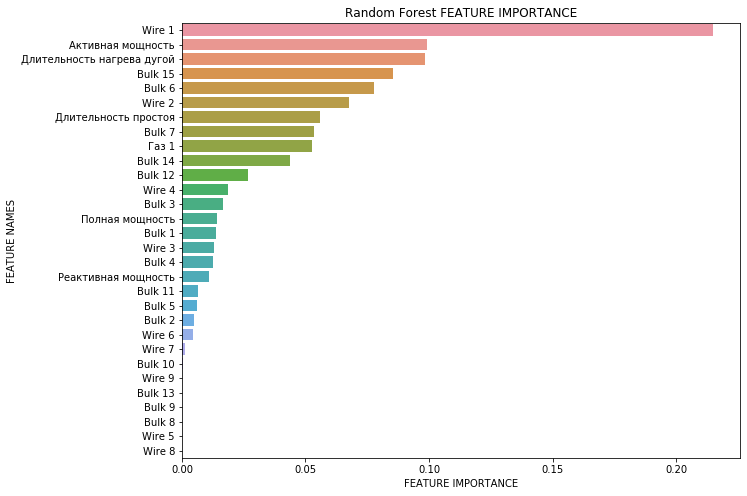

In [87]:
plot_feature_importance(model_RanFor.feature_importances_, X_train.columns, 'Random Forest')

По feature importance видно, что некоторые удаленные столбцы по пропускам имеют большее влияние на результат. Видимо, изза их удаления испортилась метрика. Попробую удалить features, имеющие меньшее значение.

In [90]:
features_to_drop_FI = ['Wire 5', 'Wire 7', 'Wire 8', 'Wire 9',
                    'Bulk 8', 'Bulk 13', 'Bulk 9', 'Bulk 10' , 'Wire 6', 'Bulk 2', 'Bulk 5', 'Bulk 11']

X3 = X.drop(features_to_drop_FI, axis=1)
X_train_FI, X_test_FI, y_train_FI, y_test_FI = train_test_split(X3, y, test_size = 0.2, random_state=SEED)

In [108]:
model_RanFor3 = RandomForestRegressor(random_state=SEED, n_estimators = 19, max_depth = 6)
model_RanFor3.fit(X_train_FI, y_train_FI)
pred_RanFor_FI = model_RanFor3.predict(X_test_FI)
print(mean_absolute_error(pred_RanFor_FI, y_test_FI))

6.079962620999195


In [92]:
grid_params_RanFor = [
    {
        'n_estimators' : (10, 40, 1),
        'max_depth' : (2, 21, 1)
    }
]

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
mae_score = make_scorer(mean_absolute_error, greater_is_better=False)

grid = GridSearchCV(model_RanFor3, 
                    param_grid=grid_params_RanFor, 
                    scoring=mae_score, 
                    cv=cv, 
                    verbose=True)

In [ ]:
grid.fit(X_train_FI, y_train_FI)

In [ ]:
print(grid.best_estimator_)
print(grid.best_score_)
pred = grid.best_estimator_.predict(X_test_FI)
print(mean_absolute_error(pred, y_test_FI))

In [ ]:
## проверка на catboost на поверочку
model_CatBoost.fit(X_train_FI, y_train_FI)
pred_CatBoost3 = model_CatBoost.predict(X_test_FI)
print(mean_absolute_error(pred_CatBoost3, y_test_FI))

Смена комбинаций столбцов не улучшило метрику.

# 4. Общий Вывод
- Модель, обеспечившая лучшее качество предсказания - Random Forest с параметрами n_estimators = 17, max_depth = 6
- Лучший показатель mean absolute Error 6.028
- Лучшие даные для обучения - Пропуски заполненные нулями, максимальная сохранность столбцов
- Наибольшее влияние оказывают добавленные features: 'Длительность нагрева дугой', 'Длительность простоя'  , полная мощность оказывает меньшее влияние
- Наибольшее влияние оказывают стартовые features: 'wire 1', 'Активная мощность', 'Bulk 15'


##### Для улучшения качества предсказания
   - изменить комбинации столбцов для обучающих данных
   - подобрать более подходящую модель с более подходящими гиперпараметрами
   - удалить столбцы с наибольшим кол-вом пропусков, оставшиеся пропуски удалить.